<a href="https://colab.research.google.com/github/DSAlexRS/python/blob/master/MLzoomcap4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score



#preparing date

In [49]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv")

In [50]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [51]:
dic = {"yes":1,"no":0}
df["card"] = df["card"].replace(dic)


In [58]:
df.columns

Index(['card', 'reports', 'age', 'income', 'share', 'expenditure', 'owner',
       'selfemp', 'dependents', 'months', 'majorcards', 'active'],
      dtype='object')

In [64]:
categorical = ['owner', 'selfemp']
numerical = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']

#spliting data

In [52]:
df_full = df.drop("card", axis = 1)
df_full.columns

Index(['reports', 'age', 'income', 'share', 'expenditure', 'owner', 'selfemp',
       'dependents', 'months', 'majorcards', 'active'],
      dtype='object')

In [53]:
y_full = df["card"]

In [54]:
X_trainF, X_test, y_trainF, y_test = train_test_split(df_full, y_full, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_trainF, y_trainF, test_size=0.25, random_state=1)

In [55]:
print(len(X_train) + len(X_val) + len(X_test), len(df_full))
print(len(y_train) + len(y_val) + len(y_test), len(y_full))

1319 1319
1319 1319


In [56]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [57]:
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

#AUC

In [65]:
for c in numerical:
    auc = roc_auc_score(y_train, X_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[c])
    print('%9s, %.3f' % (c, auc))

  reports, 0.717
      age, 0.524
   income, 0.591
    share, 0.989
expenditure, 0.991
dependents, 0.533
   months, 0.529
majorcards, 0.534
   active, 0.604


#model

In [66]:
dv = DictVectorizer(sparse=False)

train_dict = X_train[numerical + categorical].to_dict(orient='records')
X_train1 = dv.fit_transform(train_dict)

val_dict = X_val[numerical + categorical].to_dict(orient='records')
X_val1 = dv.transform(val_dict)

In [67]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train1, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='liblinear')

In [68]:
y_pred = model.predict_proba(X_val1)[:, 1]

In [70]:
round(roc_auc_score(y_val, y_pred),3)

0.995

#presition and recall

In [91]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [92]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

In [94]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [99]:
df_scores["p-r"] = df_scores['p'] - df_scores['r']

In [111]:
df_scores[df_scores["p-r"]==0 ]

,threshold,tp,fp,fn,tn,p,r,p-r
24,0.24,206,5,5,48,0.976303,0.976303,0.0
25,0.25,206,5,5,48,0.976303,0.976303,0.0
26,0.26,206,5,5,48,0.976303,0.976303,0.0
27,0.27,206,5,5,48,0.976303,0.976303,0.0
28,0.28,206,5,5,48,0.976303,0.976303,0.0
29,0.29,206,5,5,48,0.976303,0.976303,0.0


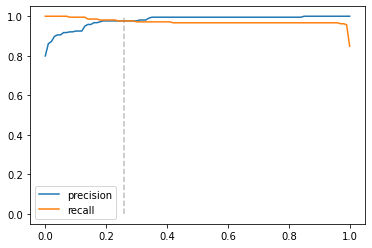

In [119]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.26, 0, 1, color='grey', linestyle='--', alpha=0.5)



plt.legend()
plt.show()

#F1


In [112]:
df_scores["f1"] = 2*(df_scores["p"]*df_scores["r"])/(df_scores["p"]+df_scores["r"])

In [113]:
df_scores[df_scores["f1"]==df_scores["f1"].max()]

,threshold,tp,fp,fn,tn,p,r,p-r,f1
35,0.35,205,1,6,52,0.995146,0.971564,0.023582,0.983213
36,0.36,205,1,6,52,0.995146,0.971564,0.023582,0.983213
37,0.37,205,1,6,52,0.995146,0.971564,0.023582,0.983213
38,0.38,205,1,6,52,0.995146,0.971564,0.023582,0.983213
39,0.39,205,1,6,52,0.995146,0.971564,0.023582,0.983213
40,0.40,205,1,6,52,0.995146,0.971564,0.023582,0.983213
41,0.41,205,1,6,52,0.995146,0.971564,0.023582,0.983213


#Kfolds


In [129]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = \
        train_test_split(df_full_train, test_size=0.25, random_state=1)

In [133]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[numerical + categorical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[numerical + categorical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [134]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


In [136]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.992 +- 0.006
C= 0.1, 0.995 +- 0.004
C=   1, 0.996 +- 0.003
C=  10, 0.996 +- 0.003


#Answers

Q1. share

Q2. 0.995

Q3. 0.3

Q4. 0.4

Q5. 0.003

Q.6 1